# Kuramoto-Sivashinsky hyperbolization 

In [2]:
import numpy as np
from nodepy import rk
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.pyplot import cm
from IPython.display import HTML
font = {'size'   : 15}
matplotlib.rc('font', **font)

from IPython.display import clear_output
from time import time

fft = np.fft.fft
ifft = np.fft.ifft

In [3]:
# Third order SSPRK(3,3) method 
ssp33 = rk.loadRKM('SSP33').__num__()

# Fourth order RK(4,4) method 
rk4 = rk.loadRKM('RK44').__num__()

# 4th order ImEx method
rkex = np.array([ [0, 0, 0, 0, 0, 0],
          [1/2, 0, 0, 0, 0, 0],
          [13861/62500, 6889/62500, 0, 0, 0, 0], 
          [-116923316275/2393684061468, -2731218467317/15368042101831, 9408046702089/11113171139209, 0, 0, 0], 
          [-451086348788/2902428689909, -2682348792572/7519795681897, 12662868775082/11960479115383, 3355817975965/11060851509271, 0, 0], 
          [647845179188/3216320057751, 73281519250/8382639484533, 552539513391/3454668386233, 3354512671639/8306763924573, 4040/17871, 0] 
        ])

rkim = np.array([ [0, 0, 0, 0, 0, 0],
                  [1/4, 1/4, 0, 0, 0, 0],
                  [8611/62500, -1743/31250, 1/4, 0, 0, 0],
                  [5012029/34652500, -654441/2922500, 174375/388108, 1/4, 0, 0],
                  [15267082809/155376265600, -71443401/120774400, 730878875/902184768, 2285395/8070912, 1/4, 0],
                  [82889/524892, 0, 15625/83664, 69875/102672, -2260/8211, 1/4]
                ])

c = np.array([0, 1/2, 83/250, 31/50, 17/20, 1])
b = np.array([82889/524892, 0, 15625/83664, 69875/102672, -2260/8211, 1/4])
bhat = np.array([4586570599/29645900160, 0, 178811875/945068544, 814220225/1159782912, -3700637/11593932, 61727/225920])

In [4]:
# Initial condition
def IC(x):
    u = np.exp(-1*x**2)
    return u

## Solution of the original KS  equation

In [5]:
def KSE_stiff_rhs(xi,u): # stiff right part of the hand side
    uhat = fft(u)
    return np.real(ifft((xi**2-xi**4)*uhat))

def KSE_non_stiff_rhs(xi,u): # non-stiff part of right hand side 
    uhat = fft(u)
    return -u*np.real(ifft(1j*xi*uhat))

In [6]:
def KS_Sol(rkim, rkex, c, b, bhat, f_stiff, f_non_stiff, u0, xL, xR, N, dt, t0, tmax): 
    
    xplot = np.linspace(xL, xR, N+1); x = xplot[0:-1]; dx = x[1] - x[0]
    L = xR- xL; xi = np.fft.fftfreq(N) * N * 2*np.pi / L
    
    tt = np.zeros(1); t = t0; tt[0] = t; u_in = u0(x)

    uu = np.zeros((1,np.size(u_in))); uu[0,:] = u_in.copy()
    
    s = len(rkim); Rim = np.zeros((s,len(u_in))); Rex = np.zeros((s,len(u_in)))
    
    # time loop
    while t < tmax and not np.isclose(t, tmax):
        clear_output(wait=True)
        if t + dt > tmax:
            dt = tmax - t
        for i in range(s):
            rhs = uu[-1].copy()
            if i>0:
                for j in range(i):
                    rhs += dt*(rkim[i,j]*Rim[j,:] + rkex[i,j]*Rex[j,:])
                                
            # solving stages 
            Coeff =1/(1 - dt*rkim[i,i]*(xi**2-xi**4))
            g_j = np.real(np.fft.ifft(Coeff*np.fft.fft(rhs)))
            
            Rim[i,:] = f_stiff(xi,g_j)
            Rex[i,:] = f_non_stiff(xi,g_j)

        inc = dt*sum([ b[j]*(Rim[j]+Rex[j]) for j in range(s)])    
        unew = uu[-1]+inc; t+= dt
        tt = np.append(tt, t)
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0)  
        
        print("Time = %1.2f)"%(tt[-1]))
        
    return x, tt, uu

## Solution of the approximate KSH equation

In [7]:
# Initial condition for the hyperbolized KS system
def Hyp_KS_q0(xL,xR,x,t0):   
    m = len(x); dx = x[1] - x[0]; L = xR - xL
    xi = np.fft.fftfreq(m)*m*2*np.pi/L
    q = np.zeros((4,len(x)))
    q[0,:] = IC(x)
    
    # Initial conditions for derivatives v, w, and z from the 
    # function values u using spectral differentiation 
    q[1,:] = np.real(ifft( 1j*xi*fft(q[0,:]) ))
    q[2,:] = np.real(ifft( (1j*xi)**2*fft(q[0,:]) ))
    q[3,:] = np.real(ifft( (1j*xi)**3*fft(q[0,:]) ))
    
    return q

# Right hand side function of the hyperbolized KS system
def Hyp_KS_rhs(q, xi, c1, c2, c3, filtr):
    q_t = np.zeros_like(q)
    u = q[0,:]; v = q[1,:]; w = q[2,:]; z = q[3,:]
    
    # RHS 2
    q_t[0,:] = -u*np.real( ifft( 1j*xi*fft(u)*filtr ) ) - np.real( ifft( 1j*xi*fft(v) ) ) - np.real( ifft( 1j*xi*fft(z) ) )
    q_t[1,:] = c1*(np.real( ifft( 1j*xi*fft(w) ) ) - z)
    q_t[2,:] = c2*(np.real( ifft( 1j*xi*fft(v) ) ) -w)
    q_t[3,:] = -c3*(np.real( ifft( 1j*xi*fft(u) ) ) -v)
    
    return q_t

# Time stepping method for the hyperbolized system
def Hyp_KS_ERK(q,xi,c1,c2,c3,rhs,rkm,dt,filtr):
    s = len(rkm)
    g = np.zeros((s, *q.shape)) 
    R = np.zeros((s, *q.shape)) 
    for i in range(s):
        g[i,:] = q.copy()
        for j in range(i):
            g[i,:] += dt*rkm.A[i,j]*R[j,:]
        R[i,:] = rhs(g[i,:],xi, c1, c2, c3, filtr)
        inc = sum([rkm.b[i]*R[i] for i in range(s)]) 
        
    q_new = q+dt*inc
    
    return q_new

In [8]:
def Hyp_KS_Sol(rhs,xL,xR,m,t0,q0,tmax,c1,c2,c3,ERK_fun,rkm):
    
    L = xR-xL # Length of the domain
    xplot = np.linspace(xL, xR, m+1)
    x = xplot[0:-1]; dx = x[1] - x[0]
    xi = np.fft.fftfreq(m)*m*2*np.pi/L
    
    # Initial state vector 
    q = q0(xL,xR,x,t0)
    
    tt = np.zeros(1); t = t0; tt[0] = t
    uu = np.zeros((1,np.size(q[0,:]))); uu[0,:] = q[0,:].copy()
    
    
    # Time step based on the CFL number
    u_max = np.max(np.abs(q[0,:]))
    s_max = max(c1,c2,0.5*(u_max+np.sqrt(u_max**2+4*c3)))
    print('Maximum speed = %1.2f'%s_max)
    #dt = (mu*dx)/s_max with CFL number = mu and s_max = maximum speed
    mu = 0.8; dt = mu*dx/s_max
    
    # use 2/3 filter to avoid aliasing instability 
    filtr = np.ones_like(xi)
    use_filter = True
    if use_filter:
        xi_max = np.max(np.abs(xi))
        filtr[np.where(np.abs(xi)>xi_max*2./3)] = 0.
    
    while t < tmax and not np.isclose(t, tmax):
        clear_output(wait=True)
        if t + dt > tmax:
            dt = tmax - t

        q_new = ERK_fun(q,xi,c1,c2,c3,rhs,rkm,dt,filtr)
        q = q_new.copy();  t+= dt
        
        tt = np.append(tt, t)
        uu = np.append(uu, np.reshape(q_new[0,:].copy(), (1,len(q_new[0,:]))), axis=0)  
        
        print("m = %d, t = %.2f"%(m, t))
    
    
    return x, tt, uu

In [9]:
# Numerical solution
xL = -20*np.pi; xR = 20*np.pi; t0 = 0; tmax = 50

In [10]:
q0 = Hyp_KS_q0; m = 256; rhs = Hyp_KS_rhs; ERK_fun = Hyp_KS_ERK; rkm = rk4;

## KSH with $\tau^{-1} = 50$

In [11]:
%%time
c1 = 50; 
x_KSH_1, tt_KSH_1, uu_KSH_1 = Hyp_KS_Sol(rhs,xL,xR,m,t0,q0,tmax,c1,c1,c1,ERK_fun,rkm)

m = 256, t = 50.00
CPU times: user 6.45 s, sys: 3.24 s, total: 9.69 s
Wall time: 10.2 s


In [12]:
%%time
dt = tt_KSH_1[1] - tt_KSH_1[0]; 
f_stiff = KSE_stiff_rhs; f_non_stiff = KSE_non_stiff_rhs; u0 = IC; 
x_KS_1, tt_KS_1, uu_KS_1 = KS_Sol(rkim, rkex, c, b, bhat, f_stiff, f_non_stiff, u0, xL, xR, m, dt, t0, tmax)

Time = 50.00)
CPU times: user 6.61 s, sys: 3.23 s, total: 9.84 s
Wall time: 10.4 s


In [13]:
XX_KS_1, TT_KS_1 = np.meshgrid(x_KS_1, tt_KS_1)
XX_KSH_1, TT_KSH_1 = np.meshgrid(x_KSH_1, tt_KSH_1)

In [18]:
vmin = -1.5 # Minimum value for the color scale
vmax = 1.5 # Maximum value for the color scale

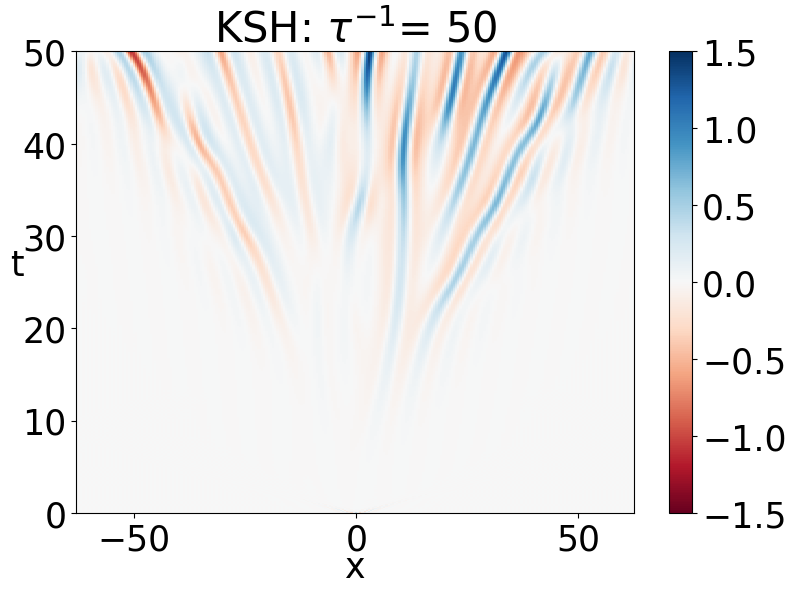

In [19]:
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(9,6))
skip1 = round(len(TT_KSH_1)/1000)
# Plot 
cs1 = ax.pcolor(XX_KSH_1[::skip1,:], TT_KSH_1[::skip1,:], (uu_KS_1[::skip1,:]-uu_KSH_1[::skip1,:]), cmap=cm.RdBu, vmin=vmin, vmax=vmax)
fig.colorbar(cs1)
ax.set_xlabel("x", labelpad=-5)
ax.set_ylabel("t", rotation=0)
ax.set_title(r"KSH: $\tau^{-1}$= %d" % (c1))
plt.savefig("Hyp_KS_Err_%d.pdf" % (c1), dpi = 100)

## KSH with $\tau^{-1} = 100$

In [16]:
%%time
c2 = 100;
x_KSH_2, tt_KSH_2, uu_KSH_2 = Hyp_KS_Sol(rhs,xL,xR,m,t0,q0,tmax,c2,c2,c2,ERK_fun,rkm)

m = 256, t = 50.00
CPU times: user 15.2 s, sys: 8.83 s, total: 24 s
Wall time: 25 s


In [20]:
%%time
dt = tt_KSH_2[1] - tt_KSH_2[0]; 
f_stiff = KSE_stiff_rhs; f_non_stiff = KSE_non_stiff_rhs; u0 = IC; 
x_KS_2, tt_KS_2, uu_KS_2 = KS_Sol(rkim, rkex, c, b, bhat, f_stiff, f_non_stiff, u0, xL, xR, m, dt, t0, tmax)

Time = 50.00)
CPU times: user 16.5 s, sys: 11.3 s, total: 27.8 s
Wall time: 28.6 s


In [21]:
XX_KS_2, TT_KS_2 = np.meshgrid(x_KS_2, tt_KS_2)
XX_KSH_2, TT_KSH_2 = np.meshgrid(x_KSH_2, tt_KSH_2)

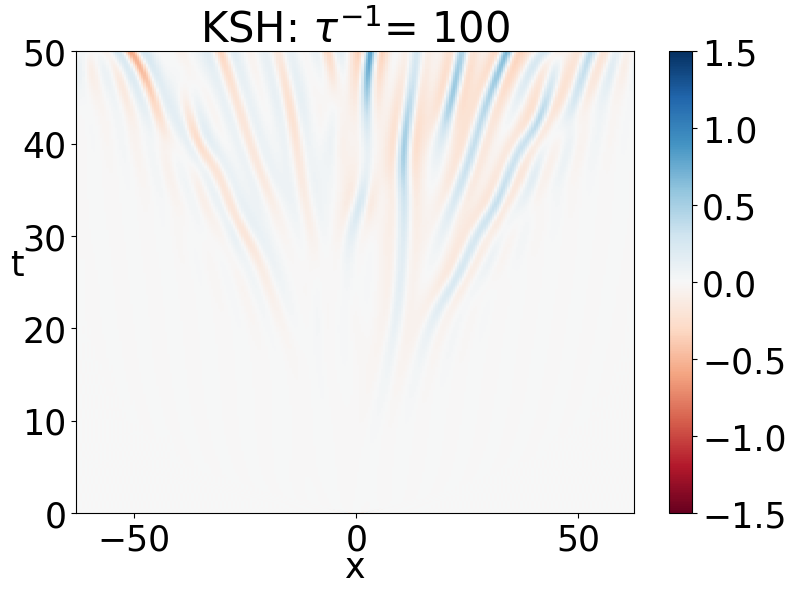

In [29]:
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(9,6))
skip2 = round(len(TT_KSH_2)/1000)
# Plot 
cs2 = ax.pcolor(XX_KSH_2[::skip2,:], TT_KSH_2[::skip2,:], (uu_KS_2[::skip2,:]-uu_KSH_2[::skip2,:]), cmap=cm.RdBu, vmin=vmin, vmax=vmax)
fig.colorbar(cs2)
ax.set_xlabel("x", labelpad=-5)
ax.set_ylabel("t", rotation=0)
ax.set_title(r"KSH: $\tau^{-1}$= %d" % (c2))
plt.savefig("Hyp_KS_Err_%d.pdf" % (c2), dpi = 100)

## KSH with $\tau^{-1} = 400$

In [23]:
%%time
c3 = 400; 
x_KSH_3, tt_KSH_3, uu_KSH_3 = Hyp_KS_Sol(rhs,xL,xR,m,t0,q0,tmax,c3,c3,c3,ERK_fun,rkm)

m = 256, t = 50.00
CPU times: user 2min 17s, sys: 2min 14s, total: 4min 32s
Wall time: 4min 46s


In [24]:
%%time
dt = tt_KSH_3[1] - tt_KSH_3[0]; 
f_stiff = KSE_stiff_rhs; f_non_stiff = KSE_non_stiff_rhs; u0 = IC; 
x_KS_3, tt_KS_3, uu_KS_3 = KS_Sol(rkim, rkex, c, b, bhat, f_stiff, f_non_stiff, u0, xL, xR, m, dt, t0, tmax)

Time = 50.00)
CPU times: user 2min 34s, sys: 2min 43s, total: 5min 18s
Wall time: 5min 36s


In [25]:
XX_KS_3, TT_KS_3 = np.meshgrid(x_KS_3, tt_KS_3)
XX_KSH_3, TT_KSH_3 = np.meshgrid(x_KSH_3, tt_KSH_3)

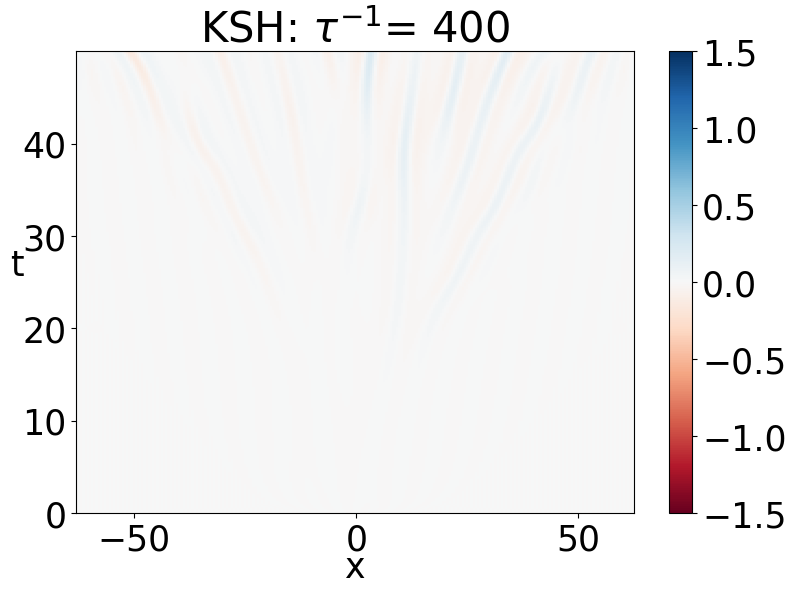

In [26]:
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(9,6))
skip3 = round(len(TT_KSH_3)/1000)
# Plot 
cs3 = ax.pcolor(XX_KSH_3[::skip3,:], TT_KSH_3[::skip3,:], (uu_KS_3[::skip3,:]-uu_KSH_3[::skip3,:]), cmap=cm.RdBu, vmin=vmin, vmax=vmax)
fig.colorbar(cs3)
ax.set_xlabel("x", labelpad=-5)
ax.set_ylabel("t", rotation=0)
ax.set_title(r"KSH: $\tau^{-1}$= %d" % (c3))
plt.savefig("Hyp_KS_Err_%d.pdf" % (c3), dpi = 100)

## Solution plot 

In [27]:
L = xR - xL; xi = np.fft.fftfreq(m)*m*2*np.pi/L

def spectral_representation(x0,uhat):
    u_fun = lambda y : np.real(np.sum(uhat*np.exp(1j*xi*(y-x0))))/len(uhat)
    u_fun = np.vectorize(u_fun)
    return u_fun

c1_1st_spectral = spectral_representation(xL,fft(uu_KSH_1[-1,:]))
c1_2nd_spectral = spectral_representation(xL,fft(uu_KSH_2[-1,:])) 
c1_3rd_spectral = spectral_representation(xL,fft(uu_KSH_3[-1,:])) 
KS_ref_spectral = spectral_representation(xL,fft(uu_KS_3[-1,:])) 

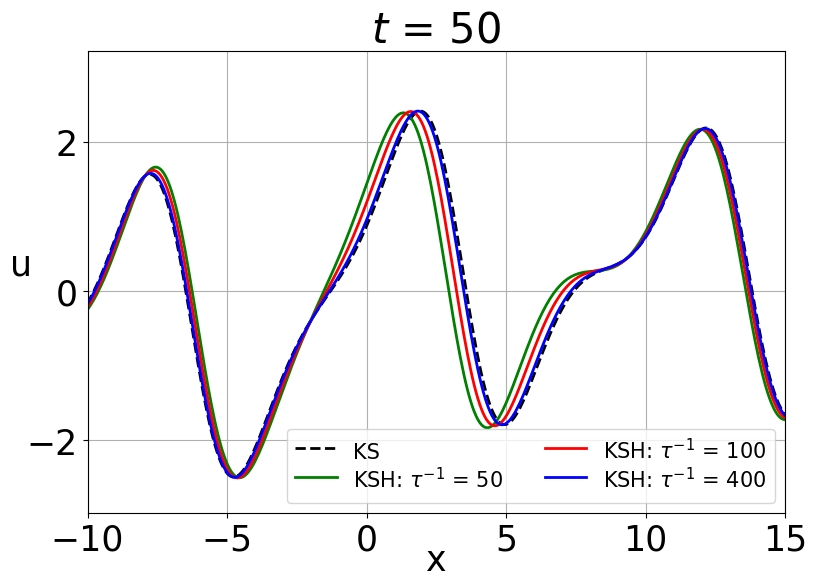

In [28]:
# Solution comparison
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(9, 6))

x_fine = np.linspace(xL,xR,2000)

plt.plot(x_fine,KS_ref_spectral(x_fine),'--k', linewidth=2,label = 'KS')
plt.plot(x_fine,c1_1st_spectral(x_fine),'-g', linewidth=2,label = r'KSH: $\tau^{-1}$ = %d'%c1)
plt.plot(x_fine,c1_2nd_spectral(x_fine),'-r', linewidth=2,label = r'KSH: $\tau^{-1}$ = %d'%c2)
plt.plot(x_fine,c1_3rd_spectral(x_fine),'-b', linewidth=2,label = r'KSH: $\tau^{-1}$ = %d'%c3)

plt.title('$t$ = %d'%tmax)
plt.xlim(-10, 15)
plt.xlabel("x", labelpad=-10)
plt.ylabel("u", rotation=0)
plt.grid()
plt.legend(fontsize=15,ncol=2,handleheight=1.7, labelspacing=0.01,loc='lower right')
plt.savefig("Hyp_KS_Sol_Comp.pdf")

# KS solution

In [16]:
f_stiff = KSE_stiff_rhs; f_non_stiff = KSE_non_stiff_rhs; u0 = IC; 
x_KS, tt_KS, uu_KS= KS_Sol(rkim, rkex, c, b, bhat, f_stiff, f_non_stiff, u0, xL, xR, 1024, 0.01, t0, tmax)

Time = 50.00)


In [17]:
XX_KS, TT_KS = np.meshgrid(x_KS, tt_KS)

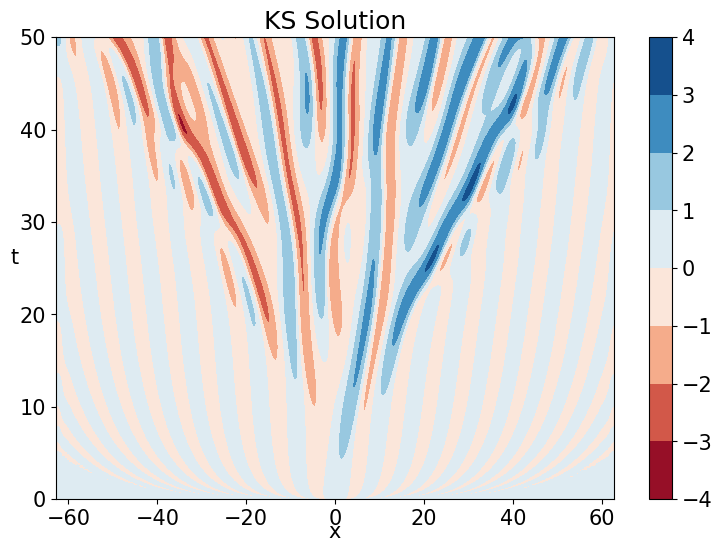

In [20]:
# plot the result
skip = round(len(TT_KS)/1000)

fig, ax = plt.subplots(figsize=(9,6))
cs = ax.contourf(XX_KS[::skip,:], TT_KS[::skip,:], uu_KS[::skip,:], cmap=cm.RdBu)
fig.colorbar(cs)

ax.set_xlabel("x", labelpad=-5)
ax.set_ylabel("t", rotation=0)
ax.set_title("KS Solution")
plt.savefig("KS_Solution.pdf", dpi = 100)